In [1]:
import numpy as np
import pandas as pd
import datetime
xls = pd.ExcelFile('churn.xlsx')

In [2]:
# read the training set into dataframe

training = pd.read_excel(xls, 'training data set')
last_date=datetime.datetime(2014,1,20)

In [3]:
### drop the data in first order that are not in a good format
c1=[]
for i in range(0,len(training)):
    if type(training['firstorder'].iloc[i])!=datetime.datetime:
        c1.append(i)
training=training.drop(training.index[c1])

# drop the data in last order that are not in a good format
c2=[]
for i in range(0,len(training)):
    if type(training['lastorder'].iloc[i])!=datetime.datetime:
        c2.append(i)
training=training.drop(training.index[c2])

In [4]:
# remove duplicates according to the custid
training = training.drop_duplicates(subset = 'custid', keep = 'first', inplace=False)
# drop na's according to rows
training = training.dropna(axis=0, how='any')
# tranform the categorical data into multi-dummy variables(encoding categorical variables)
training = pd.get_dummies(training, prefix=['favday', 'city'], columns=['favday', 'city'])

# Change the date type
training['created']=(last_date-training['created']).astype('timedelta64[D]')
training['firstorder']=(last_date-training['firstorder']).astype('timedelta64[D]')
training['lastorder']=(last_date-training['lastorder']).astype('timedelta64[D]')

# drop the variables that are not useful
training = training.drop(['custid','train'], axis=1)

In [5]:
# independent variable in trianing set
trainingx = training.iloc[:, 1:]

# dependent variable in training set
trainingy = training.retained

In [6]:
# same procuedure for test set
test = pd.read_excel(xls, 'test data set')
last_date=datetime.datetime(2018,1,21)
c1=[]
for i in range(0,len(test)):
    if type(test['firstorder'].iloc[i])!=datetime.datetime:
        c1.append(i)
test=test.drop(test.index[c1])

c2=[]
for i in range(0,len(test)):
    if type(test['lastorder'].iloc[i])!=datetime.datetime:
        c2.append(i)
test=test.drop(test.index[c2])

In [7]:
# remove duplicates according to the custid
test = test.drop_duplicates(subset = 'custid', keep = 'first', inplace=False)
# drop na's according to rows
test = test.dropna(axis=0, how='any')
# tranform the categorical data into multi-dummy variables(encoding categorical variables)
test = pd.get_dummies(test, prefix=['favday', 'city'], columns=['favday', 'city'])

#Deal with dates
test['created']=(last_date-test['created']).astype('timedelta64[D]')
test['firstorder']=(last_date-test['firstorder']).astype('timedelta64[D]')
test['lastorder']=(last_date-test['lastorder']).astype('timedelta64[D]')

# drop the useless variables
test = test.drop(['custid','train'], axis=1)

# test dependent variable
testy = test.retained
# test independent variables
testx = test.iloc[:, 1:]

In [8]:
# start building the decision tree model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# plant 1000 trees
rf = RandomForestClassifier(n_estimators= 1000, random_state= 42)
rf.fit = rf.fit(trainingx, trainingy)

# Validate the model on the test data
predictions = rf.predict(testx)

# evaluate the model accuracy on test data set
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
accuracy = accuracy_score(testy, predictions) * 100

In [9]:
print('Accuracy on the random forest decision tree is', str(round(accuracy,3))+'%')

Accuracy on the random forest decision tree is 96.778%


In [10]:
# roc evaluation
false_positive_rate, true_positive_rate, thresholds = roc_curve(testy, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

ROC = round(roc_auc_score(testy, predictions),3) * 100

In [11]:
print("ROC statistic for Random Forest is ", ROC,'%')

ROC statistic for Random Forest is  93.5 %


In [12]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(trainingx, trainingy)
y_pred = log_clf.predict(testx)
print('Accuracy on the logistic regression is', str(round(accuracy_score(testy, y_pred)*100, 3)) + '%')

Accuracy on the logistic regression is 94.33%


In [13]:
# roc evaluation
false_positive_rate, true_positive_rate, thresholds = roc_curve(testy, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ROC = round(roc_auc_score(testy, y_pred),3) * 100

In [14]:
print("ROC statistic for logistics regression is ", ROC,'%')

ROC statistic for logistics regression is  90.2 %


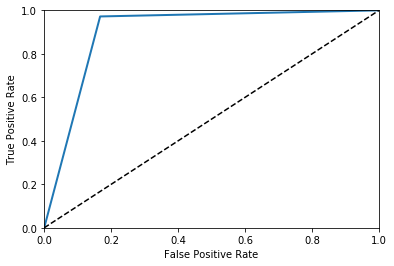

In [15]:
# visualisation
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [28]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

In [46]:
feature_importances=dict()

for i in range(0,len(trainingx.columns)):
    feature_importances[trainingx.columns[i]]=importances[i]
    

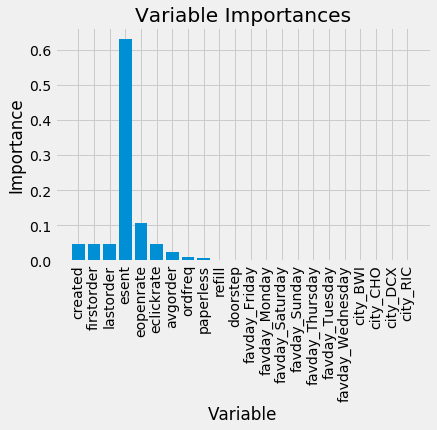

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values,feature_importances.values(), orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_importances.keys(), rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');